**0. Постановка задачи**

Задача классификации - зависимость рейтинга фильма от продолжительности, возрастных ограничений, наличия в фильме насилия, ругательст, наготы, алкоголя, пугающих моментов.

**1. Чтение данных**

In [38]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
url = "https://raw.githubusercontent.com/PavelKitaev/machine_learning/main/imdb.csv"
data = pd.read_csv(url)
rows = data.shape[0]
columns = data.shape[1]

print("Строки - ", rows)
print("Столбцы - ", columns)
data.head(10)

Строки -  6178
Столбцы -  14


,Name,Date,Rate,Votes,Genre,Duration,Type,Certificate,Episodes,Nudity,Violence,Profanity,Alcohol,Frightening
0,No Time to Die,2021,7.6,"107,163","Action, Adventure, Thriller",163,Film,PG-13,-,Mild,Moderate,Mild,Mild,Moderate
1,The Guilty,2021,6.3,"64,375","Crime, Drama, Thriller",90,Film,R,-,None,None,Severe,None,Moderate
2,The Many Saints of Newark,2021,6.4,"27,145","Crime, Drama",120,Film,R,-,Moderate,Severe,Severe,Moderate,Moderate
3,Venom: Let There Be Carnage,2021,6.4,"30,443","Action, Adventure, Sci-Fi",97,Film,PG-13,-,None,Moderate,Moderate,Mild,Moderate
4,Dune,2021,8.3,"84,636","Action, Adventure, Drama",155,Film,PG-13,-,None,Moderate,None,Mild,Moderate
5,Ted Lasso,2021,8.8,"117,562","Comedy, Drama, Sport",30,Series,TV-MA,23,Mild,None,Severe,Mild,None
6,Free Guy,2021,7.3,"153,835","Action, Adventure, Comedy",115,Film,PG-13,-,Mild,Moderate,Moderate,None,Mild
7,House of the Dragon,2021,No Rate,No Votes,"Action, Adventure, Drama",None,Series,None,10,No Rate,No Rate,No Rate,No Rate,No Rate
8,What If...?,2021,7.6,"51,959","Animation, Action, Adventure",None,Series,TV-14,18,None,Moderate,Mild,Mild,Moderate
9,Sex Education,2021,8.3,"220,201","Comedy, Drama",45,Series,TV-MA,25,Severe,Mild,Severe,Moderate,Mild


**Подготовка данных**

Удаление строк с отсутствующими значениями, а также корректировка типов данных.

In [40]:
# Удаление строк, которые характеризуют сериалы
data = data.loc[data['Type'] != 'Series']

# Удаление столбца с жанрами и количеством эпизодов
data = data.drop("Episodes", axis=1)
data = data.drop("Genre", axis=1)

# Удаление строк с отсутствующими значениями
data = data.loc[data['Rate'] != 'No Rate']
data = data.loc[data['Votes'] != 'No Votes']
data = data.loc[data['Duration'] != 'None']

#data = data.loc[data['Nudity'] != 'No Rate']
#data = data.loc[data['Violence'] != 'No Rate']
#data = data.loc[data['Profanity'] != 'No Rate']
#data = data.loc[data['Alcohol'] != 'No Rate']
#data = data.loc[data['Frightening'] != 'No Rate']

data = data.loc[data['Certificate'] != 'Passed']
data = data.loc[data['Certificate'] != 'Not Rated']

# Удаление запятой из значений 'Votes' для корректного преобразования в int
data['Votes'] = data['Votes'].str.replace(',', '')

# Преобразование данных о наличии в фильме насилия, алкоголя,
# пугающих моментов, матов, наготы в числовые данные
# 0 - Отсутствует (None)
# 1 - Мало (Mild)
# 2 - Умерено (Moderate)
# 3 - Много (Severe)

data['Nudity'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)
data['Violence'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)
data['Profanity'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)
data['Alcohol'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)
data['Frightening'].replace(['No Rate', 'None', 'Mild', 'Moderate', 'Severe'], [1, 0, 1, 2, 3], inplace=True)

# Корректировка типов
data['Rate'] = data['Rate'].astype('float64')
data['Votes'] = data['Votes'].astype('int64')
data['Duration'] = data['Duration'].astype('int64')
data['Certificate'] = data['Certificate'].astype('category')
data['Nudity'] = data['Nudity'].astype('int64')
data['Violence'] = data['Violence'].astype('int64')
data['Profanity'] = data['Profanity'].astype('int64')
data['Alcohol'] = data['Alcohol'].astype('int64')
data['Frightening'] = data['Frightening'].astype('int64')

# Преобразование данных о возрастном рейтинге (С интерпритацией на систему рейтинга РФ)
data['Certificate'].replace(['None', 'GP', 'Unrated', 'E', 'TV-Y', 'TV-Y7', 'G', 'TV-G',
    'PG', 'Approved', 'TV-PG', 'PG-13', 'M', 'M-PG', 'M/PG', 'TV-14', 'R', 'TV-MA', 'NC-17', '(Banned)', 'X'],
    [0, 0, 0, 0, 0, 7, 14, 14, 14, 14, 14, 12, 12, 12, 12, 14, 18, 18, 18, 18, 18], inplace=True)

# Переводим рейтинг из 10-ти бальной системы в условную 4-х бальную
# 0-3.9 - плохо (1)
# 4-5.9 - нормально (2)
# 6-7.9 - хорошо (3)
# 8-10 - отлично (4)

data['Rate'] = data['Rate'].mask(((data['Rate'] >= 0) & (data['Rate'] <= 3.9)), 1)
data['Rate'] = data['Rate'].mask(((data['Rate'] >= 4.0) & (data['Rate'] <= 5.9)), 2)
data['Rate'] = data['Rate'].mask(((data['Rate'] >= 6.0) & (data['Rate'] <= 7.9)), 3)
data['Rate'] = data['Rate'].mask(((data['Rate'] >= 8.0) & (data['Rate'] <= 10.0)), 4)
data['Rate'] = data['Rate'].astype('int64')

rows = data.shape[0]
columns = data.shape[1]

print("Строки - ", rows)
print("Столбцы - ", columns)

Строки -  4084
Столбцы -  12


До обработки данные содержали 6178 строк. После - 4084

Убедимся в отсутствии пропущенных значений:

In [41]:
numerical_columns = ['Rate', 'Votes', 'Duration']
data[numerical_columns].count(axis = 0)

Rate        4084
Votes       4084
Duration    4084
dtype: int64

In [42]:
categorical_columns = ['Certificate', 'Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening']
data[categorical_columns].count(axis = 0)

Certificate    4084
Nudity         4084
Violence       4084
Profanity      4084
Alcohol        4084
Frightening    4084
dtype: int64

**2. Визуализация данных**

In [43]:
# Количественные признаки
data.describe()

,Date,Rate,Votes,Duration,Nudity,Violence,Profanity,Alcohol,Frightening
count,4084.000000,4084.000000,4.084000e+03,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000,4084.000000
mean,2005.601126,2.835700,1.584419e+05,110.615573,1.083986,1.669687,1.575906,1.097209,1.556807
std,14.625199,0.566593,2.144436e+05,20.807048,0.874460,0.930003,0.909238,0.675742,0.922389
min,1932.000000,1.000000,5.200000e+01,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1998.000000,3.000000,3.385175e+04,96.000000,0.000000,1.000000,1.000000,1.000000,1.000000
50%,2009.000000,3.000000,9.072300e+04,108.000000,1.000000,2.000000,1.000000,1.000000,2.000000
75%,2017.000000,3.000000,1.967550e+05,121.000000,2.000000,2.000000,2.000000,1.000000,2.000000
max,2021.000000,4.000000,2.474122e+06,242.000000,3.000000,3.000000,3.000000,3.000000,3.000000


Количественные признаки:
1. Date - Год выпуска. Первый фильм (сериал) в наборе данных выпущен в 2005 году, последний - в 2023
2. Rate - Рейтинг. Минимальный - 1, максимальный - 4
3. Votes - Количество оценок. Минимальное - 125 222, максимальное - 2 474 122
4. Duration - Продолжительность. Минимальная - 94.5, максимальное - 900 (в минутах)

Rate-Votes: 0.4445860484410097
Duration-Votes: 0.33543686955386265


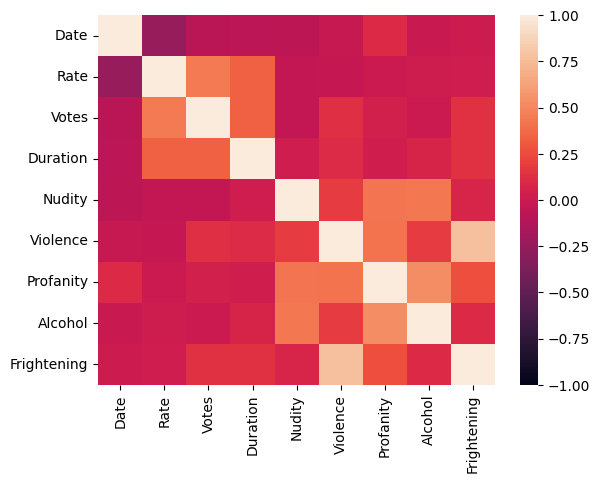

In [44]:
# Корреляционная матрица
corrMat = data.corr(numeric_only=True)
sns.heatmap(corrMat, vmin=-1.0, vmax=1.0)

print("Rate-Votes:", corrMat["Rate"]["Votes"])
print("Duration-Votes:", corrMat["Duration"]["Votes"])

Из матрицы понятно, что рейтинг зависит от количества оценок, а на факт оценки влияет продолжительность фильма.

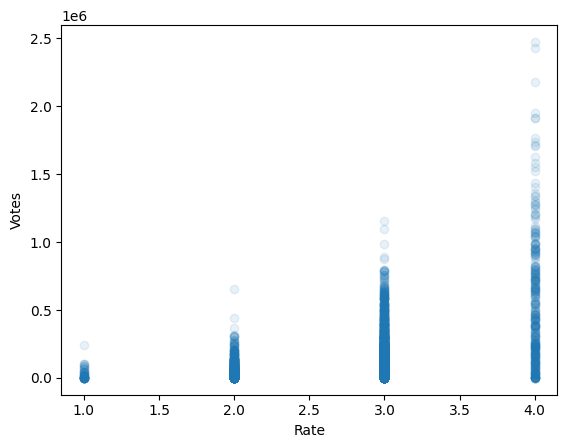

In [45]:
# Диаграмма рассеивания для признаков 'Rate', 'Votes':
plt.scatter(data['Rate'], data['Votes'], alpha=0.1)
plt.xlabel('Rate')
plt.ylabel('Votes')
pass

Можно заметить, что работы с низким рейтингом имеют малое количество оценок.

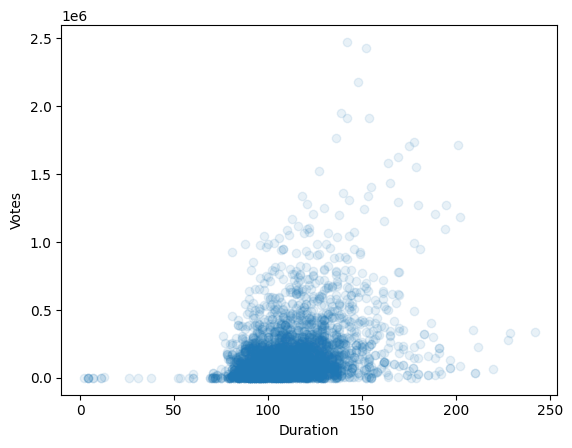

In [46]:
# Диаграмма рассеивания для признаков 'Duration', 'Votes':
plt.scatter(data['Duration'], data['Votes'], alpha=0.1)
plt.xlabel('Duration')
plt.ylabel('Votes')
pass

Здесь видно, что работы, длинной менее 70  и более 200 минут имеют малое количество оценок.

**3. Классы**

Будем классифицировать по рейтингу

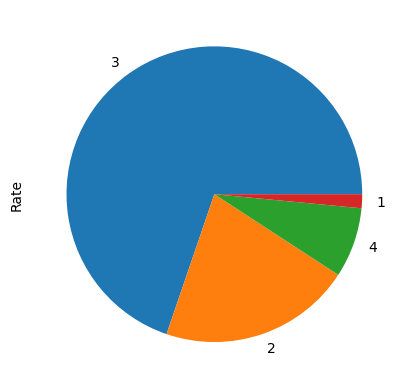

In [47]:
import collections
data['Rate'].value_counts().plot.pie();

**4. Нормализация**

Нормализация позволит повысить скорость сходимости алгоритма.

In [48]:
cls = data['Rate']
norm_columns  = ['Votes', 'Duration']
nonnorm_columns = ['Certificate', 'Nudity', 'Violence', 'Profanity', 'Alcohol', 'Frightening']
data_nonnorm = data[nonnorm_columns]

data_norm = data[norm_columns]
data_norm.describe()
data_norm = (data_norm - data_norm.mean(axis = 0))/data_norm.std(axis = 0)
data_norm.describe()

data = data[numerical_columns]
data = pd.concat((data_norm, data_nonnorm), axis = 1)
data.head(10)

,Votes,Duration,Certificate,Nudity,Violence,Profanity,Alcohol,Frightening
0,-0.239125,2.517629,12,1,2,1,1,2
1,-0.438656,-0.990798,18,0,0,3,0,2
2,-0.612268,0.451022,18,2,3,3,2,2
3,-0.596889,-0.654373,12,0,2,2,1,2
4,-0.344174,2.133144,12,0,2,0,1,2
6,-0.021483,0.210718,12,1,2,2,0,1
19,0.411115,1.123870,12,0,2,1,1,2
20,-0.708550,1.988962,18,3,3,2,1,3
22,-0.227985,1.027749,12,0,2,1,1,1
25,1.161481,1.796719,12,1,2,1,1,2


**5. Выборки**

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    data, cls, test_size = 0.3, random_state = 10)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (2858, 8)
Test: (1226, 8)


**6. Классификатор ближайших соседей**



In [50]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn import neighbors
nnb = [5, 10, 15, 20]
knn = neighbors.KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=10)
grid.fit(X_train, Y_train)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print("Оптимальное кол-во соседей - ", best_n_neighbors)

knn = neighbors.KNeighborsClassifier(n_neighbors = best_n_neighbors).fit(X_train, Y_train)

err_train = np.mean(Y_train != knn.predict(X_train))
err_test  = np.mean(Y_test  != knn.predict(X_test))

print("Ошибка на тренировочном наборе - ", err_train)
print("Ошибка на тестовом наборе - ", err_test)

Оптимальное кол-во соседей -  20
Ошибка на тренировочном наборе -  0.25087473757872636
Ошибка на тестовом наборе -  0.2830342577487765
CPU times: user 1.53 s, sys: 41.1 ms, total: 1.57 s
Wall time: 1.56 s


**7. SVC**



In [51]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
Cs = 10.**np.arange(-5, 5)
gamma_array = 10.**np.arange(-5, 5)
svc = SVC(gamma='auto')
grid = GridSearchCV(svc, cv=3, param_grid = {'C': Cs, 'gamma': gamma_array})
grid.fit(X_train, Y_train)

best_cv_err = 1 - grid.best_score_
best_C = grid.best_estimator_.C
print(best_cv_err, best_C)

0.23722815464065994 100.0
CPU times: user 2min 5s, sys: 0 ns, total: 2min 5s
Wall time: 2min 6s


**8. Выводы**

В процессе выполнения работы были прочитаны и подготовлены данные (удаление, преобразование, изменение). В итоге было исключено 2094 строки.

После изучения корреляционной матрицы были получены данные о зависимости столбцов. Рейтинг (Rate) зависит от количества оценок (Votes), а на факт оценки влияет продолжительность фильма (Duration). Также наблюдается закономерность - чем выше рейтинг фильма, тем больше он имеет оценок.

Перед применением алгоритмов, для удобства, данные были разбиты на 4 класса рейтинга.
Классификатор ближайших соседей показал ошибку на тестовом наборе 0.28 (Время - 2.1 сек).
SVC показал ошибку 0.24, но при этом затраты времени превышают прошлый алгоритм - 2 минуты 28 сек.




**К 28.12**

**Логистическая регрессия с подбором параметра**

In [52]:
from sklearn.linear_model import LogisticRegression

# lr_error = 1
# iter = 10
# for i in range(10, 150):
#   lr_model = LogisticRegression(max_iter=i)
#   lr_model.fit(X_train, Y_train)
#   error = 1 - lr_model.score(X_test, Y_test)
#   if lr_error > error:
#     lr_error = error
#     iter = i
# print("Error: ", lr_error)  # 0.2805
# print("Iter: ", iter)       # 73


lr_model = LogisticRegression(max_iter=73)
lr_model.fit(X_train, Y_train)
lr_error = 1 - lr_model.score(X_test, Y_test)
print("Error: ", lr_error)

Error:  0.28058727569331154


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


**RandomForest с подбором параметра**

In [53]:
from sklearn import ensemble

rf_error = 1
param = 2
for i in range(2, 50):
  rf_model = ensemble.RandomForestClassifier(n_estimators = i)
  rf_model.fit(X_train, Y_train)
  error = 1 - rf_model.score(X_test, Y_test)
  if rf_error > error:
    rf_error = error
    param = i

print("Error: ", rf_error)
print("Iter: ", param)

Error:  0.19249592169657426
Iter:  27


**Полносвязная нейронная сеть**

Подбор параметра alpha

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

alpha_arr = np.logspace(-5, 2, 50)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,),
                              solver = 'lbfgs', activation = 'logistic', max_iter=500, random_state = 42)
    mlp_model.fit(X_train, Y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)

    train_err.append(np.mean(Y_train != y_train_pred))
    test_err.append(np.mean(Y_test != y_test_pred))
    train_acc.append(accuracy_score(Y_train, y_train_pred))
    test_acc.append(accuracy_score(Y_test, y_test_pred))

Построим график зависимости ошибки от параметра альфа

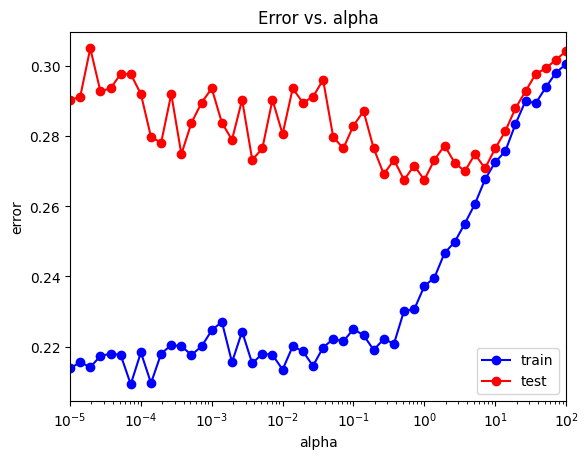

In [55]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

Полученные результаты

In [56]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
alpha_opt = alpha_arr[test_err == min_test_err]
alpha_opt = alpha_opt[0]

print("Train: ", min_train_err)
print("Test: ", min_test_err)
print("Alpha: ", alpha_opt)

Train:  0.2092372288313506
Test:  0.26753670473083196
Alpha:  0.5179474679231213


In [57]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, Y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print("Train: ", np.mean(Y_train != y_train_pred))
print("Test: ", np.mean(Y_test != y_test_pred))

Train:  0.2491252624212736
Test:  0.27569331158238175


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Подбор числа нейронов

In [ ]:
neurons = 50
err_test_best = 1
err_test_array = []
err_train_array = []

for i in range(50, 90):
  mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (i,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
  mlp_model.fit(X_train, Y_train)

  y_test_pred = mlp_model.predict(X_test)
  y_train_pred = mlp_model.predict(X_train)
  err_test = np.mean(Y_test != y_test_pred)
  err_train = np.mean(Y_train != y_train_pred)

  err_test_array.append(err_test)
  err_train_array.append(err_train)
  if err_test < err_test_best:
    err_test_best = err_test
    neurons = i

In [59]:
print("Test: ", err_test)
print("Neurons: ", neurons)

Test:  0.27814029363784665
Neurons:  82


Результаты подбора параметров показали, что оптимальное количество нейронов - 82, оптимальная альфа - 0,51

Построим график зависимости ошибки от количества нейронов при альфа 0.51

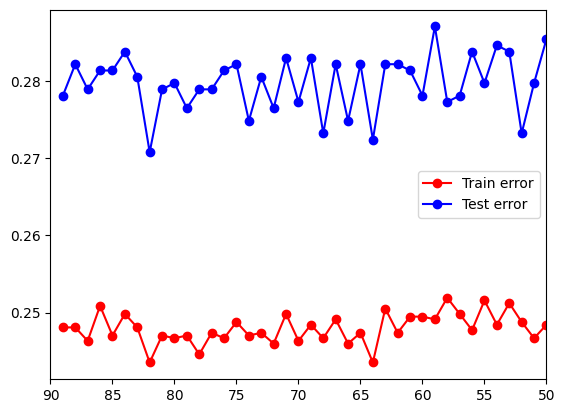

In [60]:
plt.plot(range(50, 90), err_train_array, 'r-o', label = 'Train error')
plt.plot(range(50, 90), err_test_array,  'b-o', label = 'Test error')
plt.legend(loc = 0)
plt.xlim([90, 50])
pass

In [61]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (neurons,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, Y_train)

y_test_pred = mlp_model.predict(X_test)
y_train_pred = mlp_model.predict(X_train)

err_test = np.mean(Y_test != y_test_pred)
err_train = np.mean(Y_train != y_train_pred)

print(err_test)
print(err_train)

0.2707993474714519
0.24352694191742477


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Наблюдается недообучение, т.к получаемая ошибка достаточно велика

Если брать лучший результат среди всех рассмотренных моделей, то лидирует RandomForest, который обеспечивает самую низкую ошибку - 0.19

**Confusion matrix**

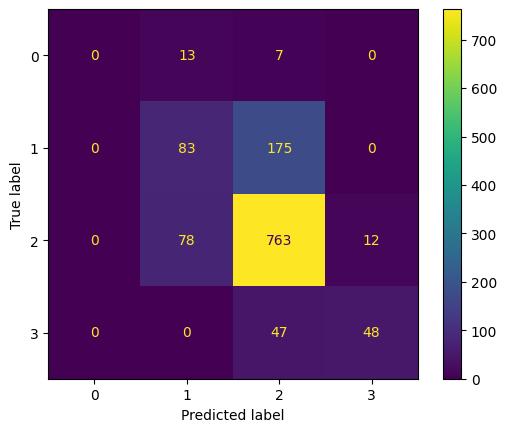

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Таблица условного рейтинга выглядит следующим образом:
0-3.9 - плохо (0)
4-5.9 - нормально (1)
6-7.9 - хорошо (2)
8-10 - отлично (3)

Из матрицы видно, что для рейтинга 6-7.9 предсказание происходит с максимальным количеством ошибок.
Для рейтингов 0-3.9 и 8-10 в целом, дела обстоят намного лучше

Подведем итог по полученным результатам от рассмотренных методов:
1. RandomForest - 0.19
2. SVC - 0.24
3. Нейросеть - 0.27
4. Логистическая регрессия - 0.28
5. Классификатор ближайших соседей - 0.28


Для данной задачи наилучший результат дает метод RandomForest